## Preparation

In [ ]:
%pip install sentencepiece
%pip install datasets

from transformers import MarianMTModel, MarianTokenizer, MarianConfig
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

tokenizer_de_en = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
model_de_en = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-de-en")

import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_de_en.to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# from datasets import load_dataset
# import pandas as pd
# # data = load_dataset("bentrevett/multi30k")
# # data = load_dataset("wmt14", 'de-en')
# train_data = load_dataset("thesistranslation/distilled-ccmatrix-de-en", split='train[:10000000]') # 10M
# test_data = load_dataset("thesistranslation/distilled-ccmatrix-de-en", split='train[10000000:10100000]') # 100K
# valid_data = load_dataset("thesistranslation/distilled-ccmatrix-de-en", split='train[10100000:10200000]') # 200K

# # data = load_dataset("yhavinga/ccmatrix", "de-en", streaming=True)
# # wmt-19 36M, wmt-18 42M
# # train_data, valid_data, test_data = pd.DataFrame(multi30k['train']), pd.DataFrame(multi30k['validation']), pd.DataFrame(multi30k['test'])
# dataset = 'ccmatrix'
# # train_data, valid_data, test_data = data['train'], data['validation'], data['test']
# from torch.utils.data import TensorDataset, DataLoader
# torch.manual_seed(1)

# train_data = pd.DataFrame(train_data['translation']) # 1 min
# test_data = pd.DataFrame(test_data['translation'])
# val_data = pd.DataFrame(valid_data['translation'])

# len(train_data), len(test_data), len(valid_data)

In [ ]:
from datasets import load_dataset
import pandas as pd
data = load_dataset("bentrevett/multi30k")

dataset = 'multi30k'
train_data, valid_data, test_data = data['train'], data['validation'], data['test']
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

len(train_data), len(test_data), len(valid_data)

(29000, 1000, 1014)

## Pipeline to create: Teacher model outputs (references for student model)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# def output_translation_texts(data, model=model_de_en, tokenizer=tokenizer_de_en, set_name='train', src="de", trg="en"):

#     tokenized_data = tokenizer(list(data[src]), text_target=list(data[trg]), return_tensors="pt", padding=True, truncation=True, add_special_tokens=True).to(device)
#     data_set = TensorDataset(tokenized_data.input_ids, tokenized_data.attention_mask, tokenized_data.labels)
#     data_loader = DataLoader(data_set, batch_size=64)
#     model.eval()
#     output_sentences = []
#     i = 0
#     with torch.no_grad():
#       for batch in data_loader:
#           i+=1
#           if i % 10 == 0:
#               print(i, '/', len(data_loader))
#           output_ids = model.generate(
#               input_ids = batch[0].to(device),
#               attention_mask = batch[1].to(device),
#               labels = batch[2].to(device),)
#           output_sentences.extend(tokenizer.batch_decode(output_ids, skip_special_tokens=True))
#     print("Successfully generate translations for {} data, src: {}, trg: {}. ".format(set_name, src, trg))
#     # torch.save(output_sentences, f'Teacher_Translations_{set_name}_{src}_{trg}.pth')
#     return output_sentences

def output_translation_texts(data,model=model_de_en, tokenizer=tokenizer_de_en, set_name='train', src="de", trg="en"):
    tokenized_data = tokenizer(list(data),return_tensors="pt", padding=True, truncation=True, add_special_tokens=True).to(device)
    # print("True")
    data_set = TensorDataset(tokenized_data.input_ids, tokenized_data.attention_mask)
    data_loader = DataLoader(data_set, batch_size=64)
    model.eval()
    output_sentences = []
    i = 0
    with torch.no_grad():
      for batch in data_loader:
          i+=1
          if i % 10 == 0:
              print(i, '/', len(data_loader))
          output_ids = model.generate(
              input_ids = batch[0].to(device),
              attention_mask = batch[1].to(device))
          output_sentences.extend(tokenizer.batch_decode(output_ids, skip_special_tokens=True))
    print("Successfully generate translations for {} data, src: {}, trg: {}. ".format(set_name, src, trg))
    # torch.save(output_sentences, f'Teacher_Translations_{set_name}_{src}_{trg}.pth')
    return output_sentences

In [ ]:
# from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# tokenizer.src_lang = "de_DE"

# def output_translation_texts(data, model=model_de_en, tokenizer=tokenizer_de_en, set_name='train', src="de", trg="en"):
#     encoded_hi = tokenizer(list(data[src]), return_tensors="pt", padding=True, truncation=True, add_special_tokens=True).to(device)
#     generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
#     tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
#     data_set = TensorDataset(tokenized_data.input_ids, tokenized_data.attention_mask, tokenized_data.labels)
#     data_loader = DataLoader(data_set, batch_size=64)
#     model.eval()
#     output_sentences = []
#     i = 0
#     with torch.no_grad():
#       for batch in data_loader:
#           i+=1
#           if i % 10 == 0:
#               print(i, '/', len(data_loader))
#           output_ids = model.generate(
#               input_ids = batch[0].to(device),
#               attention_mask = batch[1].to(device),
#               labels = batch[2].to(device),)
#           output_sentences.extend(tokenizer.batch_decode(output_ids, skip_special_tokens=True))
#     print("Successfully generate translations for {} data, src: {}, trg: {}. ".format(set_name, src, trg))
#     # torch.save(output_sentences, f'Teacher_Translations_{set_name}_{src}_{trg}.pth')
#     return output_sentences


## Pipeline to create: QE metrics for teacher model outputs

In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

### BLEU scores

In [ ]:
def map_bleu_scores_to_tokens(bleu_scores, category_num = 5):
    if category_num == 5:
        categories_ranges = list(range(20, 110, 20)) # [20, 40, 60, 80, 100]
    else:
        categories_ranges = list(range(5, 110, 10)) # [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105]

    BLEU_tokens = []

    for bleu_score in bleu_scores:
        for i, upper_bound in enumerate(categories_ranges):
            if bleu_score <= upper_bound:
                if category_num == 5:
                    BLEU_tokens.append(f'bleu_{upper_bound-20}_{upper_bound}')
                else:
                    BLEU_tokens.append(f'bleu_{upper_bound-5}')
                break

    return BLEU_tokens



In [ ]:
# def BLEU_for_teacher_translations(translations, data, model=model_de_en, tokenizer=tokenize_en, set_name='train', src="de", trg="en", load_bleu=False):
#     references = data['en']
#     if load_bleu:
#         bleu_scores = torch.load('bleu_scores_r4_{}'.format(set_name))
#     else:
#         hypotheses = [tokenizer(s) for s in translations]
#         references = [tokenizer(s) for s in references]

#         bleu_scores = []
#         for i, hypothesis in enumerate(hypotheses):
#             bleu_score = sentence_bleu(references=[references[i]], hypothesis=hypothesis)
#             bleu_scores.append(round(bleu_score, 4))
#         # torch.save(bleu_scores, 'bleu_scores_r4_{}_{}_{}'.format(set_name, src, trg))
#         bleu_scores = torch.Tensor(bleu_scores) * 100
#         bleu_tokens_c5 = map_bleu_scores_to_tokens(bleu_scores)
#         # torch.save(bleu_tokens_c5, 'bleu_tokens_c5_{}_{}_{}'.format(set_name, src, trg))
#         bleu_tokens_c10 = map_bleu_scores_to_tokens(bleu_scores, 10)
#         # torch.save(bleu_tokens_c10, 'bleu_tokens_c10_{}_{}_{}'.format(set_name, src, trg))

#     return bleu_scores, bleu_tokens_c5, bleu_tokens_c10

def BLEU_for_teacher_translations(translations, data, model=model_de_en, tokenizer=tokenize_en, set_name='train', src="de", trg="en", load_bleu=False):
    references = data
    if load_bleu:
        bleu_scores = torch.load('bleu_scores_r4_{}'.format(set_name))
    else:
        hypotheses = [s.split() for s in translations]
        references = [s.split() for s in references]

        bleu_scores = []
        for i, hypothesis in enumerate(hypotheses):
            bleu_score = sentence_bleu(references=[references[i]], hypothesis=hypothesis)
            bleu_scores.append(round(bleu_score, 4))
        # torch.save(bleu_scores, 'bleu_scores_r4_{}_{}_{}'.format(set_name, src, trg))
        bleu_scores = torch.Tensor(bleu_scores) * 100
        bleu_tokens_c5 = map_bleu_scores_to_tokens(bleu_scores)
        # torch.save(bleu_tokens_c5, 'bleu_tokens_c5_{}_{}_{}'.format(set_name, src, trg))
        bleu_tokens_c10 = map_bleu_scores_to_tokens(bleu_scores, 10)
        # torch.save(bleu_tokens_c10, 'bleu_tokens_c10_{}_{}_{}'.format(set_name, src, trg))

    return bleu_scores, bleu_tokens_c5, bleu_tokens_c10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# train_outputs = output_translation_texts(train_data)
import pandas as pd
import torch
wmt_data_ref = torch.load("/content/drive/MyDrive/Master_Project/Data/references_100000.pth")
# wmt_data_path = "/content/drive/MyDrive/Master_Project/Data/data/val.de"

# with open(wmt_data_path,"r") as file:
#     wmt_data = file.readlines()

# with open(wmt_data_ref_path,"r") as file:
#     wmt_data_ref = file.readlines()[:len(wmt_data)+1]
# print(len(wmt_data_ref))
# wmt_data_ref = wmt_data_ref[:len(wmt_data)].tolist()
f = open('ref_data.txt','w')
for line in wmt_data_ref:
  f.write(line+'\n')
f.close()




# train_outputs = torch.load('Targets_T.pth')
# train_bleu = BLEU_for_teacher_translations(train_outputs, train_data)
# test_outputs = output_translation_texts(test_data, set_name="test")
# test_bleu = BLEU_for_teacher_translations(test_outputs, test_data)
# valid_outputs = output_translation_texts(valid_data, set_name="validation")
# valid_bleu = BLEU_for_teacher_translations(valid_outputs, valid_data)

In [ ]:
bleu_scores, bleu_tokens_c5, bleu_tokens_c10 = BLEU_for_teacher_translations(wmt_outputs,wmt_data_ref)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
import matplotlib.pyplot as plt
def plot_bleu_distribution(bleu_scores):
    plt.hist(bleu_scores, bins=20, color='blue', alpha=0.7)

    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of BLEU Scores')

    plt.show()

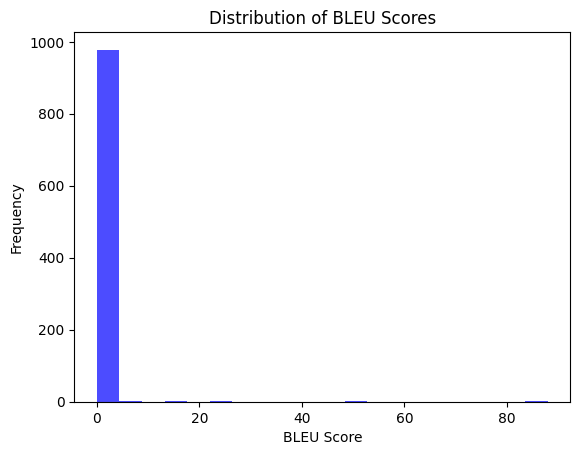

In [ ]:
plot_bleu_distribution(bleu_scores)
# bleu_scores

In [ ]:
src, trg = 'de', 'en'
torch.save({'train': train_outputs, 'test': test_outputs, 'validation': valid_outputs}, f'Teacher_Translations_{dataset}_{src}_{trg}.pth')
torch.save({'train': train_bleu[0], 'test': test_bleu[0], 'validation': valid_bleu[0]}, f'bleu_scores_r4_{dataset}_{src}_{trg}.pth')
torch.save({'train':train_bleu[1], 'test': test_bleu[1], 'validation': valid_bleu[1]}, f'bleu_tokens_c5_{dataset}_{src}_{trg}.pth')
torch.save({'train':train_bleu[2], 'test': test_bleu[2], 'validation': valid_bleu[2]}, f'bleu_tokens_c10_{dataset}_{src}_{trg}.pth')